In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)




# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)



def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)



#def a(t): # as per RD
    #return np.sqrt(2 * H_0 * t)
    
#def rho_DM(t):
    #return 0.85 * ρ_m0 * (a(t)**-3)  

    
def a(t):
    return  np.sqrt(2 * t * (a_eq**2))  *  ((3/(4 * π * G * ρ_eq))**(-1/2))


def V_shell(r_outer, r_inner):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


def rho_DM(t):
    return (ρ_eq/2) * ((a(t)/a_eq)**(-3))  


def mfdm_shell_initial(r, t):
    return rho_DM(t) * ((4/3) * np.pi * (r**3)) 



def V_shell(r_outer, r_inner):
    #delta_r = r_outer - r_inner
    #if np.isclose(delta_r, 0, rtol=1e-12, atol=1e-20):
       # return 1e-10  
    #else:
        return (4/3) * np.pi * (r_outer**3 - r_inner**3)


def shells_mass(ri_arr, N, initial_density):
    m_shell = np.zeros(N)
    for j in range(N):
        if j == 0:
            m_shell[j] = initial_density * V_shell(ri_arr[j], 0)
        else:
            m_shell[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])
    return m_shell


def shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt):
    delta_M_arr = shells_mass(ri_arr, N, initial_density)   
    rho_shell = np.zeros(N)
    for j in range(N - 1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], 0)
            rho_shell[j] = (delta_M_arr[1] + delta_M_arr[0])/delta_V if delta_V > 0 else rho_sol[j, i-1]
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i])
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            rho_shell[j] = (delta_M_arr[j] + delta_M_arr[j+1])/delta_Vsum if delta_Vsum > 0 else rho_sol[j, i-1]

    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_shell[-1] = delta_M_arr[-1]/delta_V_last if delta_V_last > 0 else rho_sol[-1, i-1]
    return rho_shell







def shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP):
    rta_mask = [[] for _ in range(N)]
    tta_mask = [[] for _ in range(N)]
    for i in range(len(t_arr) - 1):
        t = t_arr[i]
        dt_i = dt[i]
        rho_arr = shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt)
        rho_sol[:, i] = rho_arr
        QP_arr = np.zeros(N)      
        if QP==True:
            grad_rho = np.gradient(rho_arr, r_sol[:, i], edge_order=2)
            laplacian_rho = (1 / (r_sol[:, i]**2)) * np.gradient((r_sol[:, i]**2) * grad_rho, r_sol[:, i], edge_order=2)
            qp_term = (laplacian_rho / rho_arr) - ((1 / 2) * (grad_rho**2) / (rho_arr**2))
            QP_arr = (1 / 4) * np.gradient(qp_term, r_sol[:, i], edge_order=2)
        else:
            QP_arr = np.zeros_like(r_sol[:, i])
        for j in range(N):
            if not mask_active[j]:
                continue
            dv_dt = 0.0
            if Hubble==True:
                dv_H_dt = -r_sol[j, i] / (4 * (t**2))
                dv_dt += dv_H_dt
            if gravity==True:
                dv_G_dt = -1 / (r_sol[j, i]**2) if r_sol[j, i] > 0 else 0
                dv_dt += dv_G_dt
            if QP==True:
                dv_QP_dt = QP_arr[j]
                dv_dt += dv_QP_dt
            v_next = v_sol[j, i] + dv_dt * dt_i
            r_next = r_sol[j, i] + v_sol[j, i] * dt_i
            if not turnaround_detected[j]:
                rta_mask[j].append(r_sol[j, i])
                tta_mask[j].append(t_arr[i])
            if not turnaround_detected[j] and v_sol[j, i] > 0 and v_next < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i + 1]
                r_ta_arr[j] = r_next
                rta_mask[j].append(r_next)
                tta_mask[j].append(t_arr[i+1])
                
                
            #if turnaround_detected[j] and r_next < 1e-10:
                #mask_active[j] = False
                #cutoff_index[j] = i
               # continue

            r_sol[j, i + 1] = r_next
            v_sol[j, i + 1] = v_next
    return r_sol, v_sol, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask



def shells_evolution2(N, t_arr, dt, ri_arr, Hubble, gravity, QP):
    rta_mask = [[] for _ in range(N)]
    tta_mask = [[] for _ in range(N)]

    for i in range(len(t_arr) - 1):
        t = t_arr[i]
        dt_i = dt[i]

        rho_arr = shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt)
        rho_sol[:, i] = rho_arr

        QP_arr = np.zeros(N)
        if QP:
            grad_rho = np.gradient(rho_arr, r_sol[:, i], edge_order=2)
            laplacian_rho = (1 / (r_sol[:, i]**2)) * np.gradient((r_sol[:, i]**2) * grad_rho, r_sol[:, i], edge_order=2)
            qp_term = (laplacian_rho / rho_arr) - ((1 / 2) * (grad_rho**2) / (rho_arr**2))
            QP_arr = (1 / 4) * np.gradient(qp_term, r_sol[:, i], edge_order=2)

        for j in range(N):
            if not mask_active[j]:
                continue
            dv_dt = 0
            if Hubble:
                dv_H_dt = -r_sol[j, i] / (4 * (t**2))
                dv_dt += dv_H_dt
            if gravity:
                dv_G_dt = -1 / (r_sol[j, i]**2) if r_sol[j, i] > 0 else 0
                dv_dt += dv_G_dt
            if QP:
                dv_QP_dt = QP_arr[j]
                dv_dt += dv_QP_dt
            v_next = v_sol[j, i] + dv_dt * dt_i
            r_next = r_sol[j, i] + v_sol[j, i] * dt_i
            rta_mask[j].append(r_sol[j, i])
            tta_mask[j].append(t_arr[i])
            if not turnaround_detected[j] and v_sol[j, i] > 0 and v_next < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i + 1]
                r_ta_arr[j] = r_next
                cutoff_index[j] = i + 1
                r_sol[j, i + 1:] = r_ta_arr[j]  # 0.5 * r_ta_arr[j]
                v_sol[j, i + 1:] = v_sol[j, i] # 0.5 * v_sol[j, i]
                mask_active[j] = False
                continue
            r_sol[j, i + 1] = r_next
            v_sol[j, i + 1] = v_next

    return r_sol, v_sol, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask


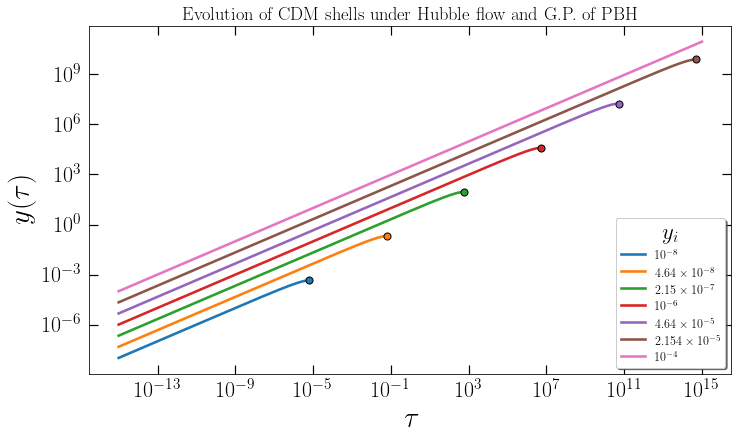

In [14]:
t_i, t_f = 1e-15, 1e15
r_min, r_max = 1e-8, 1e-4
N = 7
ri_arr = np.geomspace(r_min, r_max, N)
t_arr = np.geomspace(t_i, t_f, 10000)
dt = np.gradient(t_arr)

initial_density = 1e-20
r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))

r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr / (2 * t_arr[0])


mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)



delta_M_arr = shells_mass(ri_arr, N, initial_density)   
QP = False
gravity = True
Hubble = True


r_sol, v_sol, cutoff_index,  r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution2(N, t_arr, dt, ri_arr,  Hubble, gravity, QP)



fig, ax1 = plt.subplots(figsize=(11.5, 6.4))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


for j in range(N):
    color = colors[j]
    if turnaround_detected[j]:
        ta_index = cutoff_index[j] if cutoff_index[j] is not None else np.argmax(t_arr >= t_ta_arr[j])
        ax1.loglog(t_arr[:ta_index], r_sol[j, :ta_index], color=colors[j])
        plt.scatter(t_ta_arr[j], r_ta_arr[j], color=colors[j], edgecolors='black', zorder=5, s=50, marker='o')
    else:
        ax1.loglog(t_arr, r_sol[j, :], color=colors[j])

        
lines = ax1.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2, 3, 4, 5, 6]], [r'$10^{-8}$', r'$4.64\times10^{-8}$', r'$2.15\times10^{-7}$', r'$10^{-6}$', 
                                                                   r'$4.64\times10^{-5}$', r'$ 2.154\times10^{-5}$', r'$10^{-4}$'],prop = {'size':12.2},
              loc = 'lower right',shadow = True, title = '$y_{i}$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 25)
    
ax1.add_artist(legend1)

ax1.tick_params(axis='x', pad=7.9)
ax1.tick_params(axis='y', pad=7.9)    
plt.xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$y(\tau)$', fontsize= 29, labelpad = 6)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Evolution of CDM shells under Hubble flow and G.P. of PBH', fontsize= 18.5)
plt.savefig('CDM_shells.pdf', bbox_inches = 'tight')
plt.show()

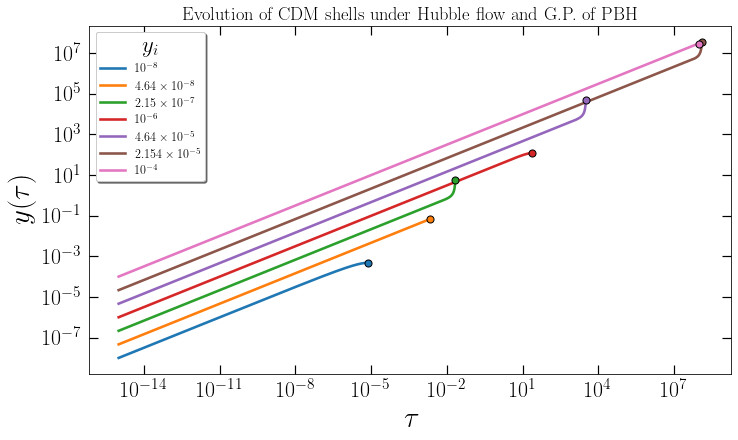

In [15]:
t_i, t_f = 1e-15, 1e15
r_min, r_max = 1e-8, 1e-4
N = 7
ri_arr = np.geomspace(r_min, r_max, N)
t_arr = np.geomspace(t_i, t_f, 10000)
dt = np.gradient(t_arr)

initial_density = 1e-20
r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))

r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr / (2 * t_arr[0])


mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)



delta_M_arr = shells_mass(ri_arr, N, initial_density)   
QP = True
gravity = True
Hubble = True


r_sol, v_sol, cutoff_index,  r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution2(N, t_arr, dt, ri_arr,  Hubble, gravity, QP)



fig, ax1 = plt.subplots(figsize=(11.5, 6.4))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']


for j in range(N):
    color = colors[j]
    if turnaround_detected[j]:
        ta_index = cutoff_index[j] if cutoff_index[j] is not None else np.argmax(t_arr >= t_ta_arr[j])
        ax1.loglog(t_arr[:ta_index], r_sol[j, :ta_index], color=colors[j])
        plt.scatter(t_ta_arr[j], r_ta_arr[j], color=colors[j], edgecolors='black', zorder=5, s=50, marker='o')
    else:
        ax1.loglog(t_arr, r_sol[j, :], color=colors[j])

        
lines = ax1.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2, 3, 4, 5, 6]], [r'$10^{-8}$', r'$4.64\times10^{-8}$', r'$2.15\times10^{-7}$', r'$10^{-6}$', 
 r'$4.64\times10^{-5}$', r'$ 2.154\times10^{-5}$', r'$10^{-4}$'],prop = {'size':12.2},
loc = 'upper left',shadow = True, title = '$y_{i}$' ,title_fontsize = 23, facecolor = 'white',fontsize = 25)
    
ax1.add_artist(legend1)
ax1.tick_params(axis='x', pad=7.9)
ax1.tick_params(axis='y', pad=7.9)    
plt.xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$y(\tau)$', fontsize= 29, labelpad = 6)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Evolution of CDM shells under Hubble flow and G.P. of PBH', fontsize= 18.5)

plt.savefig('FDM_shells.pdf', bbox_inches = 'tight')
plt.show()